# Prepare data

In [1]:
import json
import os

# Read json annotations
with open('../data/train/_annotations.coco.json') as f:
    train_annotations = json.load(f)
with open('../data/valid/_annotations.coco.json') as f:
    valid_annotations = json.load(f)
with open('../data/test/_annotations.coco.json') as f:
    test_annotations = json.load(f)

train_annotations.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [2]:
train_annotations['categories']

[{'id': 0, 'name': 'Tumor', 'supercategory': 'none'},
 {'id': 1, 'name': '0', 'supercategory': 'Tumor'},
 {'id': 2, 'name': '1', 'supercategory': 'Tumor'}]

In [3]:
import pandas as pd
import cv2

# Create dataframes out of annotations
df_train = pd.DataFrame(train_annotations['annotations'])
df_train['file_name'] = [file_name['file_name'] for file_name in train_annotations['images']]
df_test = pd.DataFrame(test_annotations['annotations'])
df_test['file_name'] = [file_name['file_name'] for file_name in test_annotations['images']]
df_valid = pd.DataFrame(valid_annotations['annotations'])
df_valid['file_name'] = [file_name['file_name'] for file_name in valid_annotations['images']]

df_train.head()

,id,image_id,category_id,bbox,area,segmentation,iscrowd,file_name
0,0,0,1,"[145, 239, 168.75, 162.5]",27421.875,"[[313.75, 238.75, 145, 238.75, 145, 401.25, 31...",0,2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg
1,1,1,1,"[194, 176, 148.75, 233.75]",34770.313,"[[342.5, 176.25, 193.75, 176.25, 193.75, 410, ...",0,2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg
2,2,2,1,"[133, 173, 162.5, 185]",30062.500,"[[295, 172.5, 132.5, 172.5, 132.5, 357.5, 295,...",0,2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg
3,3,3,1,"[245, 358, 138.75, 166.25]",23067.188,"[[383.75, 357.5, 245, 357.5, 245, 523.75, 383....",0,2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg
4,4,4,1,"[80, 189, 112.5, 132.5]",14906.250,"[[192.5, 188.75, 80, 188.75, 80, 321.25, 192.5...",0,2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg


In [25]:
import torch
# Read images
train_images = torch.zeros((len(df_train['file_name']), 1, 640, 640), dtype=torch.float32)
for i, file_name in enumerate(df_train['file_name']):
    train_images[i][0] = torch.tensor(cv2.imread('../data/train/' + file_name, cv2.IMREAD_GRAYSCALE))

test_images = torch.zeros((len(df_test['file_name']), 1, 640, 640), dtype=torch.float32)
for i, file_name in enumerate(df_test['file_name']):
    test_images[i][0] = torch.tensor(cv2.imread('../data/test/' + file_name, cv2.IMREAD_GRAYSCALE))

valid_images = torch.zeros((len(df_valid['file_name']), 1, 640, 640), dtype=torch.float32)
for i, file_name in enumerate(df_valid['file_name']):
    valid_images[i][0] = torch.tensor(cv2.imread('../data/valid/' + file_name, cv2.IMREAD_GRAYSCALE))

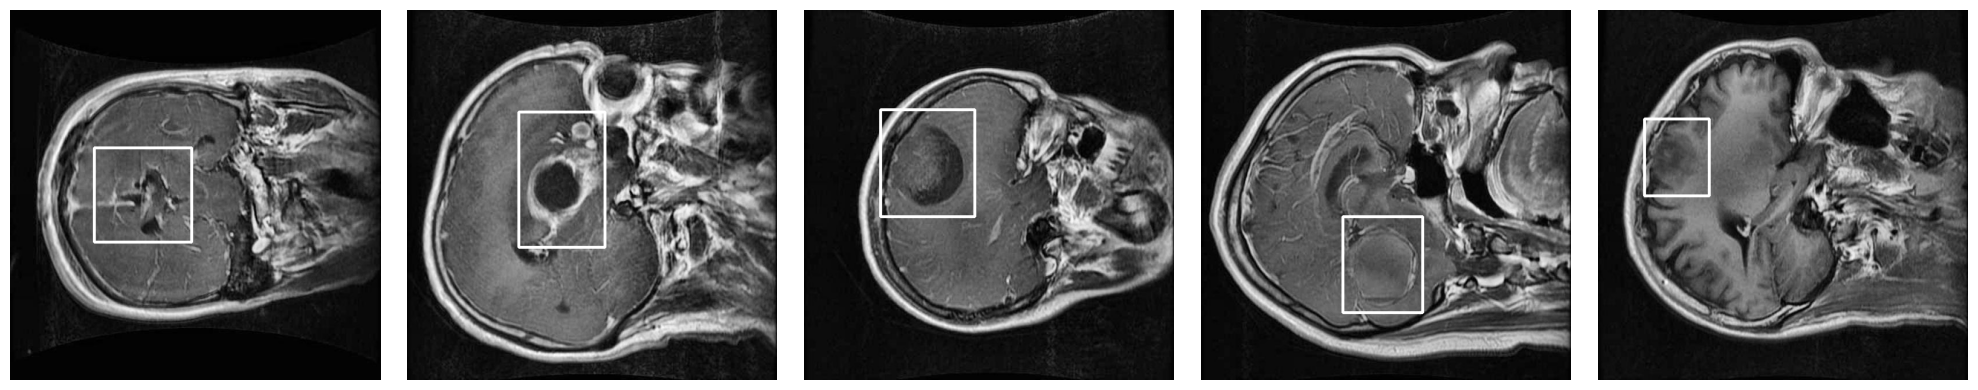

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Plot some examples
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Create a 1x5 grid for 5 images

for i in range(5):
    points = np.array(df_train['segmentation'][i]).reshape(-1, 2).astype(np.int32)

    # Make a copy of the image before drawing on it
    img_copy = train_images[i][0].numpy().copy()

    # Draw the polyline on the copied image
    cv2.polylines(img_copy, [points], True, (255, 0, 0), 3)

    # Display the modified image in the corresponding subplot
    axs[i].imshow(img_copy, cmap='gray')
    axs[i].axis('off')  # Turn off axis labels for better visualization

plt.tight_layout()  # Adjust subplot spacing
plt.show()

In [27]:
# Create masks
train_masks = torch.zeros((len(df_train['file_name']), 1, 640, 640), dtype=torch.uint8)
for i in range(len(train_images)):
    mask = np.zeros(train_images[i].shape[:2], dtype=np.uint8)
    if df_train['category_id'][i] == 2:
        train_masks[i][0] = torch.tensor(mask)
        continue
    points = np.array(df_train['segmentation'][i]).reshape(-1, 2).astype(np.int32)
    cv2.fillPoly(mask, [points], 255)
    train_masks[i][0] = torch.tensor(mask)

test_masks = torch.zeros((len(df_test['file_name']), 1, 640, 640), dtype=torch.uint8)
for i in range(len(test_images)):
    mask = np.zeros(test_images[i].shape[:2], dtype=np.uint8)
    if df_test['category_id'][i] == 2:
        test_masks[i][0] = torch.tensor(mask)
        continue
    points = np.array(df_test['segmentation'][i]).reshape(-1, 2).astype(np.int32)
    cv2.fillPoly(mask, [points], 255)
    test_masks[i][0] = torch.tensor(mask)
    
valid_masks = torch.zeros((len(df_valid['file_name']), 1, 640, 640), dtype=torch.uint8)
for i in range(len(valid_images)):
    mask = np.zeros(valid_images[i].shape[:2], dtype=np.uint8)
    if df_valid['category_id'][i] == 2:
        valid_masks[i][0] = torch.tensor(mask)
        continue
    points = np.array(df_valid['segmentation'][i]).reshape(-1, 2).astype(np.int32)
    cv2.fillPoly(mask, [points], 255)
    valid_masks[i][0] = torch.tensor(mask)

# Create a dataloder

In [28]:
import torch
from torch.utils.data import TensorDataset, DataLoader


# Create TensorDataset objects
train_dataset = TensorDataset(train_images, train_masks)
test_dataset = TensorDataset(test_images, test_masks)

# Define the batch size
batch_size = 32

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Model

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features)
        self.encoder2 = UNet._block(features, features * 2)
        self.encoder3 = UNet._block(features * 2, features * 4)
        self.encoder4 = UNet._block(features * 4, features * 8)

        self.bottleneck = UNet._block(features * 8, features * 16)

        self.decoder4 = UNet._block(features * 16, features * 8)
        self.decoder3 = UNet._block(features * 8, features * 4)
        self.decoder2 = UNet._block(features * 4, features * 2)
        self.decoder1 = UNet._block(features * 2, features)

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)

        self.conv_final = nn.Conv2d(features, out_channels, kernel_size=1)

    @staticmethod
    def _block(in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.encoder3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.encoder4(F.max_pool2d(enc3, kernel_size=2, stride=2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv_final(dec1))


In [32]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else device)

# Initialize model, loss function, and optimizer
model = UNet(in_channels=1, out_channels=1).to(device)  # assuming grayscale CT scans
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, masks)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


RuntimeError: MPS backend out of memory (MPS allocated: 16.13 GB, other allocations: 1.57 GB, max allowed: 18.13 GB). Tried to allocate 1.56 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).